In [2]:
!pip install ultralytics opencv-python pillow matplotlib tqdm pandas scikit-learn

  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)

In [41]:
import shutil
from pathlib import Path
from PIL import Image
import random

In [19]:
data_dir = Path("dataset/images")
image_out = Path("dataset/clean_img")
def is_image_ok(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception as e:
        return False
    
hashes = {}
good, bad = 0,0
for img in data_dir.rglob("*.jpg"):
    if not is_image_ok(img):
        print("Corrupted",img)
        bad += 1
        continue
    h = hash(img.read_bytes())
    if h in hashes:
        print("Duplicate",img, "==",hashes[h])
        bad += 1
        continue
    hashes[h] = str(img)
    shutil.copy(img,image_out / img.name)
    good += 1
print(f"Clened images saved. Good: {good}, Bad: {bad}")

Clened images saved. Good: 32823, Bad: 0


In [20]:
import hashlib
hashes = {}
for img_path in data_dir.glob("*.jpg"):
    with open(img_path, "rb") as f:
        filehash = hashlib.md5(f.read()).hexdigest()
    if filehash in hashes:
        print(f"Duplicate: {img_path} and {hashes[filehash]}")
    else:
        hashes[filehash] = img_path

In [40]:
import json
from pprint import pprint

ann_json = "dataset/annotations.json"

with open(ann_json, 'r') as f:
    ann = json.load(f)

print("Top-level keys:", ann.keys())

print("\nNumber of annotations:", len(ann['annotations']))
print("Number of categories:", len(ann['categories']))

# Show a sample annotation
print("\nSample annotation:")
pprint(ann['annotations'][0])

# Show a sample category
print("\nSample category:")
pprint(ann['categories'][0])


Top-level keys: dict_keys(['info', 'licenses', 'categories', 'annotations'])

Number of annotations: 32823
Number of categories: 8

Sample annotation:
{'altitude': 19921.6,
 'angle_phi': -0.06713105738162994,
 'angle_psi': 1.1161083340644837,
 'angle_theta': 0.06894744634628296,
 'bbox': [{'class': 1, 'height': 185, 'left': 1098, 'top': 163, 'width': 420},
          {'class': 1, 'height': 176, 'left': 1128, 'top': 421, 'width': 393},
          {'class': 0, 'height': 153, 'left': 1703, 'top': 927, 'width': 183}],
 'image_height': 1080.0,
 'image_name': 'frame_20190829091111_x_0001973.jpg',
 'image_width:': 1920.0,
 'latitude': 56.20630134795274,
 'linear_x': 0.03130074199289083,
 'linear_y': 0.028357808757573367,
 'linear_z': 0.0744575835764408,
 'longtitude': 10.18798203255313,
 'platform': 'Parrot Bebop 2',
 'time': {'day': 29,
          'hour': 9,
          'min': 11,
          'month': 8,
          'ms': 394400.0,
          'sec': 11,
          'year': 2019}}

Sample category:
'Huma

In [42]:
# Paths
data_dir = Path("dataset/images")
image_out = Path("dataset/images_subset")
image_out.mkdir(parents=True, exist_ok=True)

# Load annotations
with open("dataset/annotations.json", "r") as f:
    ann = json.load(f)

annotations = ann['annotations']

# Take 15% of dataset
subset_size = int(0.15 * len(annotations))
subset_annotations = random.sample(annotations, subset_size)

# Collect unique image names
subset_image_names = set(a['image_name'] for a in subset_annotations)

# Copy images to new folder
for img_name in subset_image_names:
    src = data_dir / img_name
    dst = image_out / img_name
    if src.exists():
        shutil.copy(src, dst)

print(f"Copied {len(subset_image_names)} images to {image_out}")

# Save new subset JSON
subset_json = {
    "info": ann["info"],
    "licenses": ann["licenses"],
    "categories": ann["categories"],
    "annotations": subset_annotations
}

with open(image_out / "annotations_subset.json", "w") as f:
    json.dump(subset_json, f, indent=2)

print("Subset annotations saved.")


Copied 4923 images to dataset/images_subset
Subset annotations saved.


In [44]:
from collections import defaultdict

# Load subset JSON
subset_json_path = image_out / "annotations_subset.json"
with open(subset_json_path, "r") as f:
    subset_ann = json.load(f)

# Build class ID → category name mapping
categories = subset_ann["categories"]
if isinstance(categories, list) and all(isinstance(c, str) for c in categories):
    classid_to_name = {i: name for i, name in enumerate(categories)}
else:
    classid_to_name = {c['id']: c['name'] for c in categories}

# Dictionary to store sets of images for each category
category_to_images = defaultdict(set)

for a in subset_ann["annotations"]:
    image_name = a["image_name"]
    for bbox in a["bbox"]:
        class_id = bbox["class"]
        category_name = classid_to_name[class_id]
        category_to_images[category_name].add(image_name)

# Count of images per category
print("Number of images containing each category:")
for cat, images in category_to_images.items():
    print(f"{cat}: {len(images)}")

Number of images containing each category:
Van: 1156
Car: 4421
Trailer: 294
Human: 700
Truck: 1176
Bus: 101
Bicycle: 141
Motorbike: 49


In [43]:
from collections import Counter

# Load the subset JSON
subset_json_path = image_out / "annotations_subset.json"
with open(subset_json_path, "r") as f:
    subset_ann = json.load(f)

# Build a mapping from class ID to category name
categories = subset_ann["categories"]
# If categories are just names in a list, use index as class ID
if isinstance(categories, list) and all(isinstance(c, str) for c in categories):
    classid_to_name = {i: name for i, name in enumerate(categories)}
else:  # handle dict format if present
    classid_to_name = {c['id']: c['name'] for c in categories}

# Count categories
category_counts = Counter()
for a in subset_ann["annotations"]:
    for bbox in a["bbox"]:
        class_id = bbox["class"]
        category_name = classid_to_name[class_id]
        category_counts[category_name] += 1

# Print results
print("Category counts in 15% subset:")
for cat, count in category_counts.items():
    print(f"{cat}: {count}")


Category counts in 15% subset:
Van: 1532
Car: 15856
Trailer: 376
Human: 762
Truck: 1389
Bus: 110
Bicycle: 168
Motorbike: 51


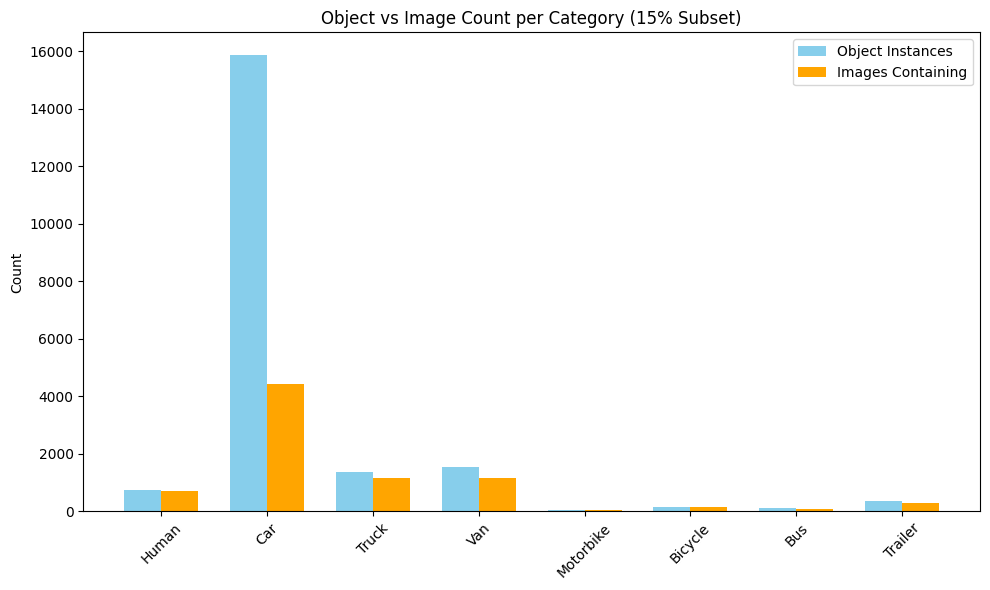

In [45]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Load subset JSON
subset_json_path = image_out / "annotations_subset.json"
with open(subset_json_path, "r") as f:
    subset_ann = json.load(f)

# Build class ID → category name mapping
categories = subset_ann["categories"]
if isinstance(categories, list) and all(isinstance(c, str) for c in categories):
    classid_to_name = {i: name for i, name in enumerate(categories)}
else:
    classid_to_name = {c['id']: c['name'] for c in categories}

# Count objects
obj_counts = Counter()
category_to_images = defaultdict(set)

for a in subset_ann["annotations"]:
    image_name = a["image_name"]
    for bbox in a["bbox"]:
        class_id = bbox["class"]
        category_name = classid_to_name[class_id]
        obj_counts[category_name] += 1
        category_to_images[category_name].add(image_name)

# Image counts
img_counts = {cat: len(images) for cat, images in category_to_images.items()}

# Sort categories
cats = list(classid_to_name.values())
obj_values = [obj_counts.get(c, 0) for c in cats]
img_values = [img_counts.get(c, 0) for c in cats]

# Plot side-by-side bar chart
x = range(len(cats))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x, obj_values, width, label='Object Instances', color='skyblue')
plt.bar([i + width for i in x], img_values, width, label='Images Containing', color='orange')
plt.xticks([i + width/2 for i in x], cats, rotation=45)
plt.ylabel("Count")
plt.title("Object vs Image Count per Category (15% Subset)")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Paths
subset_dir = Path("dataset/images_subset")
labels_dir = subset_dir / "labels"
labels_dir.mkdir(parents=True, exist_ok=True)

# Load subset annotations
with open(subset_dir / "annotations_subset.json", "r") as f:
    ann = json.load(f)

annotations = ann["annotations"]
categories = ann["categories"]

# Build class ID → category mapping
if isinstance(categories, list) and all(isinstance(c, str) for c in categories):
    classid_to_name = {i: name for i, name in enumerate(categories)}
else:
    classid_to_name = {c['id']: c['name'] for c in categories}

# Convert each annotation to YOLO format
for a in annotations:
    image_name = a["image_name"]
    img_w = a["image_width:"] if "image_width:" in a else a["image_width"]
    img_h = a["image_height"]

    yolo_lines = []
    for bbox in a["bbox"]:
        class_id = bbox["class"]
        # YOLO expects normalized values
        x_center = (bbox["left"] + bbox["width"]/2) / img_w
        y_center = (bbox["top"] + bbox["height"]/2) / img_h
        width = bbox["width"] / img_w
        height = bbox["height"] / img_h

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Write to a .txt file with same name as image
    label_file = labels_dir / f"{Path(image_name).stem}.txt"
    with open(label_file, "w") as f:
        f.write("\n".join(yolo_lines))

print(f"YOLO labels created for {len(annotations)} images in {labels_dir}")


YOLO labels created for 4923 images in dataset/images_subset/labels


In [47]:
import random
from pathlib import Path
import shutil

# Paths
subset_dir = Path("dataset/images_subset")
images_dir = subset_dir
labels_dir = subset_dir / "labels"

train_img_dir = subset_dir / "images/train"
val_img_dir = subset_dir / "images/val"
train_label_dir = subset_dir / "labels/train"
val_label_dir = subset_dir / "labels/val"

# Create folders
for d in [train_img_dir, val_img_dir, train_label_dir, val_label_dir]:
    d.mkdir(parents=True, exist_ok=True)

# List all images and shuffle
all_images = list(images_dir.glob("*.jpg"))
random.shuffle(all_images)

# Train/val split (80/20)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

def move_files(img_list, img_dest, label_dest):
    for img_path in img_list:
        # Move image
        shutil.move(str(img_path), img_dest / img_path.name)
        # Move corresponding label
        label_file = labels_dir / f"{img_path.stem}.txt"
        if label_file.exists():
            shutil.move(str(label_file), label_dest / label_file.name)

# Move train and val files
move_files(train_images, train_img_dir, train_label_dir)
move_files(val_images, val_img_dir, val_label_dir)

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}")

Train images: 3938, Val images: 985


In [48]:
from ultralytics import YOLO

# Load small YOLOv8 model (pretrained)
model = YOLO("yolov8n.pt")  # 'n' = nano, fastest for demo

# Train on your dataset
model.train(
    data="dataset_config.yaml",  # dataset YAML path
    epochs=10,                  # few epochs for demo
    imgsz=640,                  # resize images to 640x640
    batch=16,                   # adjust according to your GPU
    name="auair_15pct_yolov8"
)

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/Users/manishsharma/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.13.4 torch-2.8.0 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_config.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fra

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x14d6cbf20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  


image 1/1 /Users/manishsharma/Desktop/Projects/renoworks_asses/dataset/images_subset/images/val/frame_20190905112522_x_0002614.jpg: 384x640 2 Cars, 2 Trailers, 41.1ms
Speed: 2.0ms preprocess, 41.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


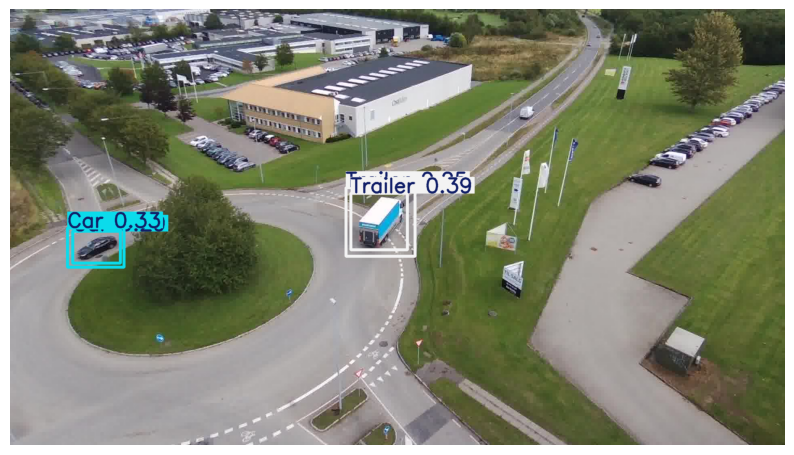


image 1/1 /Users/manishsharma/Desktop/Projects/renoworks_asses/dataset/images_subset/images/val/frame_20190905142119_x_0003437.jpg: 384x640 1 Car, 2 Trailers, 34.7ms
Speed: 1.6ms preprocess, 34.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


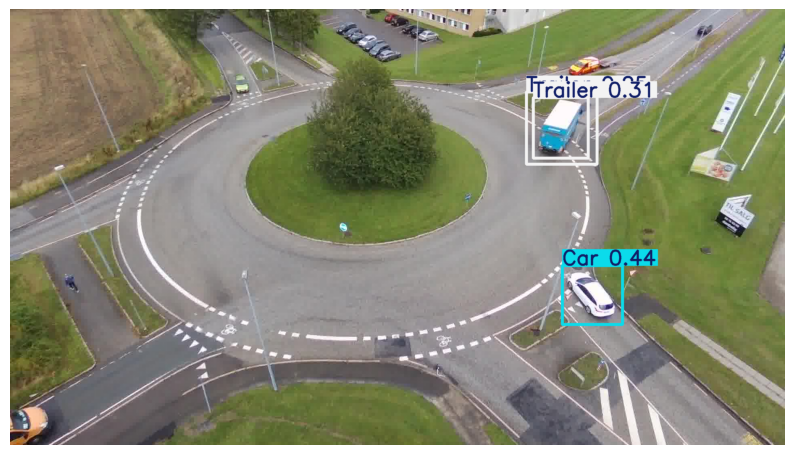


image 1/1 /Users/manishsharma/Desktop/Projects/renoworks_asses/dataset/images_subset/images/val/frame_20190905103112_x_0001428.jpg: 384x640 1 Car, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


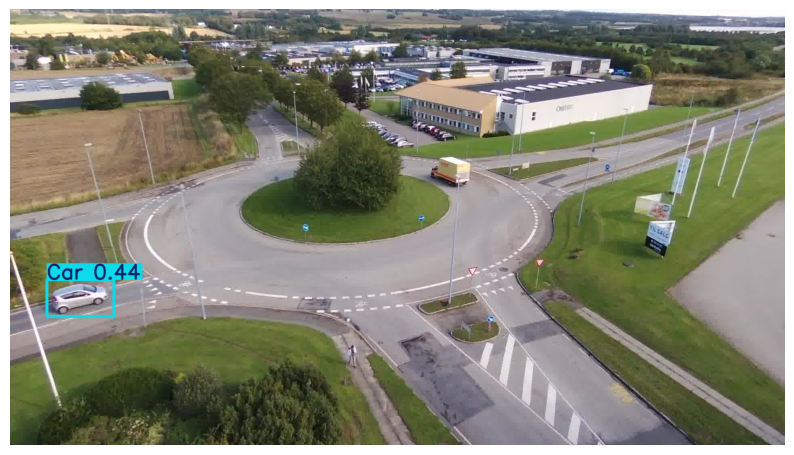


image 1/1 /Users/manishsharma/Desktop/Projects/renoworks_asses/dataset/images_subset/images/val/frame_20190905091750_x_0003464.jpg: 384x640 (no detections), 52.6ms
Speed: 1.4ms preprocess, 52.6ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


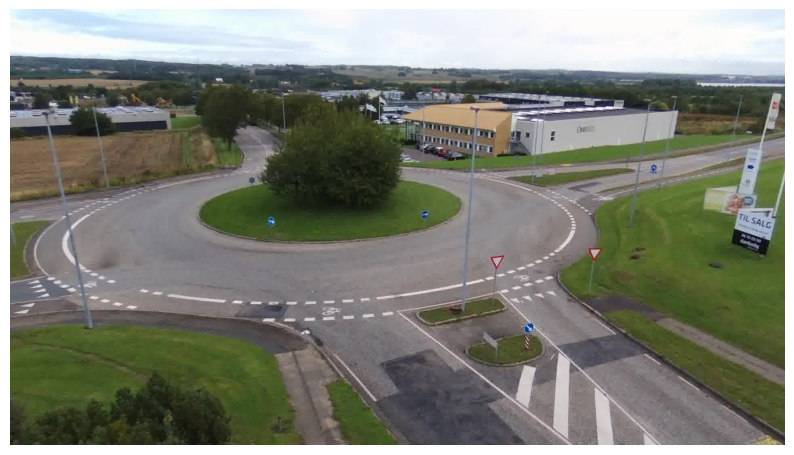


image 1/1 /Users/manishsharma/Desktop/Projects/renoworks_asses/dataset/images_subset/images/val/frame_20190905103112_xx_0000119.jpg: 384x640 1 Car, 33.5ms
Speed: 1.2ms preprocess, 33.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


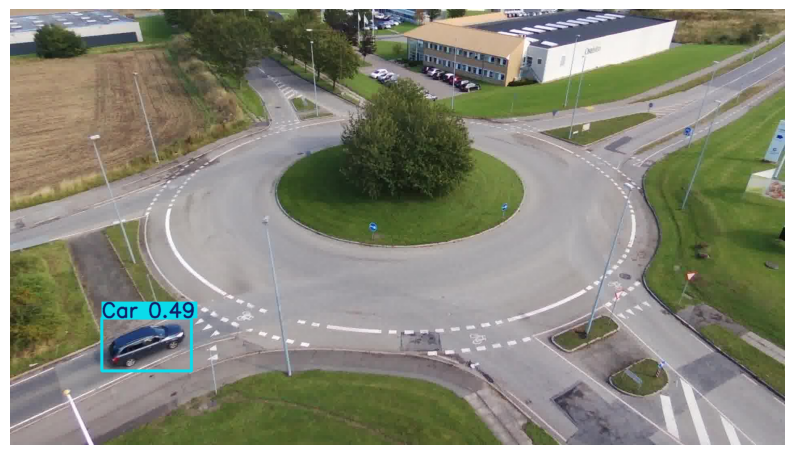

In [50]:
import cv2
from matplotlib import pyplot as plt

# Load trained model
model = YOLO("runs/detect/auair_15pct_yolov8/weights/best.pt")

# Pick a few validation images
val_images = list((Path("dataset/images_subset/images/val")).glob("*.jpg"))[:5]

for img_path in val_images:
    results = model.predict(source=str(img_path))
    # results[0].plot() returns an image array with bounding boxes
    annotated_img = results[0].plot()
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
